In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head(10)

,week,box_type,box_orders,is_marketing_week,holiday_week,weekly_subscribers,fortnightly_subscribers,month,week_of_year,quarter,day_of_year,subscriber_ratio,is_summer,is_winter,is_spring,is_fall
0,2024-04-15,FB,82,0,0,483,167.0,4,16,2,106,2.875000,0,0,1,0
1,2024-04-22,FB,90,0,0,453,176.0,4,17,2,113,2.559322,0,0,1,0
2,2024-04-29,FB,80,0,0,501,173.0,4,18,2,120,2.879310,0,0,1,0
3,2024-05-06,FB,94,1,0,556,170.0,5,19,2,127,3.251462,0,0,1,0
4,2024-05-13,FB,65,0,1,546,174.0,5,20,2,134,3.120000,0,0,1,0
5,2024-05-20,FB,97,1,0,510,179.0,5,21,2,141,2.833333,0,0,1,0
6,2024-05-27,FB,79,0,0,544,168.0,5,22,2,148,3.218935,0,0,1,0
7,2024-06-03,FB,90,0,0,561,159.0,6,23,2,155,3.506250,1,0,0,0
8,2024-06-10,FB,87,0,0,554,157.0,6,24,2,162,3.506329,1,0,0,0
9,2024-06-17,FB,97,0,0,548,165.0,6,25,2,169,3.301205,1,0,0,0


In [4]:
from data_process import process_data

feature_engineered_data = process_data('data.csv')



Raw data shape: (416, 16)
Performing feature engineering...
Processing features for box type: FB
Processing features for box type: LFV
Processing features for box type: LV
Processing features for box type: MFV
Processing features for box type: MV
Processing features for box type: SFV
Processing features for box type: SV
Processing features for box type: XSFV

Processed data saved to data.csv
Final data shape: (416, 16)


/Users/xinzhang/Codes/Oddbox/data_process.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['weekly_subscribers'] = df['weekly_subscribers'].fillna(method='ffill')


In [5]:
from train_model import train_and_evaluate_models

/Users/xinzhang/.pyenv/versions/realtime_interview_copilot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
feature_engineered_data.columns

Index(['week', 'box_type', 'box_orders', 'is_marketing_week', 'holiday_week',
       'weekly_subscribers', 'fortnightly_subscribers', 'month',
       'week_of_year', 'quarter', 'day_of_year', 'subscriber_ratio',
       'is_summer', 'is_winter', 'is_spring', 'is_fall'],
      dtype='object')


Processing box type: FB
Checking for NaN values in features...
NaN values in test features:
rolling_mean_8    10
dtype: int64
Filled NaNs in test rolling_mean_8 with training median: 83.9375
FB - Training Linear model...
FB - Linear: MAE = 15.55, RMSE = 16.03, MAPE = 18.57%
FB - Training RandomForest model...
FB - RandomForest: MAE = 8.85, RMSE = 9.69, MAPE = 10.49%
FB - Training GradientBoosting model...
FB - GradientBoosting: MAE = 10.45, RMSE = 11.11, MAPE = 12.42%
FB - Training XGBoost model...
FB - XGBoost: MAE = 9.81, RMSE = 10.54, MAPE = 11.67%
FB - Training KNN model...


08:34:34 - cmdstanpy - INFO - Chain [1] start processing
08:34:35 - cmdstanpy - INFO - Chain [1] done processing


FB - KNN: MAE = 5.07, RMSE = 6.30, MAPE = 6.16%
FB - Training ElasticNet model...
FB - ElasticNet: MAE = 8.53, RMSE = 9.75, MAPE = 10.07%
FB - ARIMA: MAE = 15.35, RMSE = 16.01, MAPE = 18.31%
FB - Prophet: MAE = 67.98, RMSE = 73.41, MAPE = 82.83%
Error creating visualization: unsupported operand type(s) for +: 'numpy.int64' and 'Timedelta'
Best model for FB: KNN (MAE: 5.07)

Model Selection Analysis:
-------------------------
The best performing model for FB is KNN with:
  - MAE: 5.07
  - RMSE: 6.30
  - MAPE: 6.16%

Comparison with other models:
  - ElasticNet: MAE 8.53 (3.46 worse than best)
  - RandomForest: MAE 8.85 (3.78 worse than best)
  - XGBoost: MAE 9.81 (4.73 worse than best)
  - GradientBoosting: MAE 10.45 (5.38 worse than best)
  - ARIMA: MAE 15.35 (10.28 worse than best)
  - Linear: MAE 15.55 (10.47 worse than best)
  - Prophet: MAE 67.98 (62.91 worse than best)

Recommendation:
The KNN model is recommended based on its superior performance metrics.

Processing box type: LF

08:34:35 - cmdstanpy - INFO - Chain [1] start processing
08:34:35 - cmdstanpy - INFO - Chain [1] done processing


LFV - KNN: MAE = 11.80, RMSE = 13.83, MAPE = 15.63%
LFV - Training ElasticNet model...
LFV - ElasticNet: MAE = 13.79, RMSE = 15.05, MAPE = 18.24%
LFV - ARIMA: MAE = 12.01, RMSE = 14.87, MAPE = 14.17%
LFV - Prophet: MAE = 1053.92, RMSE = 1388.96, MAPE = 1427.63%
Error creating visualization: unsupported operand type(s) for +: 'numpy.int64' and 'Timedelta'
Best model for LFV: XGBoost (MAE: 10.31)

Model Selection Analysis:
-------------------------
The best performing model for LFV is XGBoost with:
  - MAE: 10.31
  - RMSE: 12.32
  - MAPE: 13.20%

Comparison with other models:
  - KNN: MAE 11.80 (1.49 worse than best)
  - GradientBoosting: MAE 11.86 (1.55 worse than best)
  - ARIMA: MAE 12.01 (1.70 worse than best)
  - RandomForest: MAE 12.12 (1.81 worse than best)
  - ElasticNet: MAE 13.79 (3.48 worse than best)
  - Linear: MAE 18.45 (8.14 worse than best)
  - Prophet: MAE 1053.92 (1043.61 worse than best)

Recommendation:
The XGBoost model is recommended as it captures complex patterns 

08:34:35 - cmdstanpy - INFO - Chain [1] start processing


LV - RandomForest: MAE = 9.18, RMSE = 10.42, MAPE = 10.64%
LV - Training GradientBoosting model...
LV - GradientBoosting: MAE = 9.38, RMSE = 9.98, MAPE = 11.03%
LV - Training XGBoost model...
LV - XGBoost: MAE = 11.30, RMSE = 12.40, MAPE = 13.17%
LV - Training KNN model...
LV - KNN: MAE = 8.42, RMSE = 9.43, MAPE = 10.38%
LV - Training ElasticNet model...
LV - ElasticNet: MAE = 6.19, RMSE = 7.55, MAPE = 7.18%
LV - ARIMA: MAE = 14.41, RMSE = 16.38, MAPE = 16.67%


08:34:35 - cmdstanpy - INFO - Chain [1] done processing


LV - Prophet: MAE = 518.84, RMSE = 679.18, MAPE = 650.39%
Error creating visualization: unsupported operand type(s) for +: 'numpy.int64' and 'Timedelta'
Best model for LV: ElasticNet (MAE: 6.19)

Model Selection Analysis:
-------------------------
The best performing model for LV is ElasticNet with:
  - MAE: 6.19
  - RMSE: 7.55
  - MAPE: 7.18%

Comparison with other models:
  - KNN: MAE 8.42 (2.23 worse than best)
  - RandomForest: MAE 9.18 (2.99 worse than best)
  - GradientBoosting: MAE 9.38 (3.19 worse than best)
  - XGBoost: MAE 11.30 (5.11 worse than best)
  - ARIMA: MAE 14.41 (8.22 worse than best)
  - Linear: MAE 17.09 (10.90 worse than best)
  - Prophet: MAE 518.84 (512.65 worse than best)

Recommendation:
The ElasticNet model is recommended based on its superior performance metrics.

Processing box type: MFV
Checking for NaN values in features...
NaN values in test features:
rolling_mean_8    10
dtype: int64
Filled NaNs in test rolling_mean_8 with training median: 85.8125
MFV 

08:34:36 - cmdstanpy - INFO - Chain [1] start processing


MFV - GradientBoosting: MAE = 11.76, RMSE = 12.30, MAPE = 15.05%
MFV - Training XGBoost model...
MFV - XGBoost: MAE = 12.05, RMSE = 12.46, MAPE = 15.56%
MFV - Training KNN model...
MFV - KNN: MAE = 13.25, RMSE = 13.66, MAPE = 17.13%
MFV - Training ElasticNet model...
MFV - ElasticNet: MAE = 11.25, RMSE = 12.96, MAPE = 13.71%
MFV - ARIMA: MAE = 9.92, RMSE = 13.23, MAPE = 11.45%


08:34:36 - cmdstanpy - INFO - Chain [1] done processing


MFV - Prophet: MAE = 225.82, RMSE = 304.33, MAPE = 298.70%
Visualization saved as MFV_model_comparison.png
Best model for MFV: ARIMA (MAE: 9.92)

Model Selection Analysis:
-------------------------
The best performing model for MFV is ARIMA with:
  - MAE: 9.92
  - RMSE: 13.23
  - MAPE: 11.45%

Comparison with other models:
  - RandomForest: MAE 11.22 (1.30 worse than best)
  - ElasticNet: MAE 11.25 (1.33 worse than best)
  - GradientBoosting: MAE 11.76 (1.83 worse than best)
  - XGBoost: MAE 12.05 (2.12 worse than best)
  - Linear: MAE 12.82 (2.89 worse than best)
  - KNN: MAE 13.25 (3.33 worse than best)
  - Prophet: MAE 225.82 (215.89 worse than best)

Recommendation:
The ARIMA model is recommended as it captures the time series patterns well.
This model is specifically designed for time series forecasting and handles seasonality and trends.

Processing box type: MV
Checking for NaN values in features...
NaN values in test features:
rolling_mean_8    10
dtype: int64
Filled NaNs in te

08:34:36 - cmdstanpy - INFO - Chain [1] start processing
08:34:37 - cmdstanpy - INFO - Chain [1] done processing


MV - ARIMA: MAE = 11.40, RMSE = 13.70, MAPE = 13.43%
MV - Prophet: MAE = 64.40, RMSE = 68.61, MAPE = 80.37%
Error creating visualization: unsupported operand type(s) for +: 'numpy.int64' and 'Timedelta'
Best model for MV: RandomForest (MAE: 8.33)

Model Selection Analysis:
-------------------------
The best performing model for MV is RandomForest with:
  - MAE: 8.33
  - RMSE: 9.85
  - MAPE: 10.11%

Comparison with other models:
  - KNN: MAE 8.76 (0.44 worse than best)
  - ElasticNet: MAE 9.06 (0.74 worse than best)
  - ARIMA: MAE 11.40 (3.08 worse than best)
  - XGBoost: MAE 11.48 (3.15 worse than best)
  - GradientBoosting: MAE 11.53 (3.20 worse than best)
  - Linear: MAE 11.82 (3.49 worse than best)
  - Prophet: MAE 64.40 (56.08 worse than best)

Recommendation:
The RandomForest model is recommended as it captures complex patterns in the data.
Tree-based models are good at handling non-linear relationships and interactions between features.

Processing box type: SFV
Checking for NaN 

08:34:37 - cmdstanpy - INFO - Chain [1] start processing
08:34:37 - cmdstanpy - INFO - Chain [1] done processing


SFV - ARIMA: MAE = 11.34, RMSE = 13.38, MAPE = 13.25%
SFV - Prophet: MAE = 338.62, RMSE = 448.37, MAPE = 404.48%
Error creating visualization: unsupported operand type(s) for +: 'numpy.int64' and 'Timedelta'
Best model for SFV: KNN (MAE: 4.82)

Model Selection Analysis:
-------------------------
The best performing model for SFV is KNN with:
  - MAE: 4.82
  - RMSE: 5.97
  - MAPE: 5.74%

Comparison with other models:
  - RandomForest: MAE 5.26 (0.44 worse than best)
  - XGBoost: MAE 5.68 (0.86 worse than best)
  - ElasticNet: MAE 6.53 (1.72 worse than best)
  - GradientBoosting: MAE 7.02 (2.20 worse than best)
  - Linear: MAE 9.27 (4.45 worse than best)
  - ARIMA: MAE 11.34 (6.52 worse than best)
  - Prophet: MAE 338.62 (333.80 worse than best)

Recommendation:
The KNN model is recommended based on its superior performance metrics.

Processing box type: SV
Checking for NaN values in features...
NaN values in test features:
rolling_mean_8    10
dtype: int64
Filled NaNs in test rolling_me

08:34:37 - cmdstanpy - INFO - Chain [1] start processing
08:34:38 - cmdstanpy - INFO - Chain [1] done processing


SV - ARIMA: MAE = 11.52, RMSE = 13.36, MAPE = 13.73%
SV - Prophet: MAE = 401.54, RMSE = 517.59, MAPE = 513.07%
Error creating visualization: unsupported operand type(s) for +: 'numpy.int64' and 'Timedelta'
Best model for SV: ElasticNet (MAE: 6.29)

Model Selection Analysis:
-------------------------
The best performing model for SV is ElasticNet with:
  - MAE: 6.29
  - RMSE: 8.62
  - MAPE: 7.50%

Comparison with other models:
  - XGBoost: MAE 6.47 (0.17 worse than best)
  - GradientBoosting: MAE 7.46 (1.16 worse than best)
  - RandomForest: MAE 8.04 (1.75 worse than best)
  - KNN: MAE 10.44 (4.14 worse than best)
  - ARIMA: MAE 11.52 (5.22 worse than best)
  - Linear: MAE 12.64 (6.34 worse than best)
  - Prophet: MAE 401.54 (395.25 worse than best)

Recommendation:
The ElasticNet model is recommended based on its superior performance metrics.

Processing box type: XSFV
Checking for NaN values in features...
NaN values in test features:
rolling_mean_8    10
dtype: int64
Filled NaNs in t

08:34:38 - cmdstanpy - INFO - Chain [1] start processing


XSFV - RandomForest: MAE = 8.56, RMSE = 9.99, MAPE = 11.42%
XSFV - Training GradientBoosting model...
XSFV - GradientBoosting: MAE = 10.08, RMSE = 11.21, MAPE = 13.00%
XSFV - Training XGBoost model...
XSFV - XGBoost: MAE = 10.62, RMSE = 12.09, MAPE = 13.53%
XSFV - Training KNN model...
XSFV - KNN: MAE = 7.69, RMSE = 9.24, MAPE = 9.90%
XSFV - Training ElasticNet model...
XSFV - ElasticNet: MAE = 5.73, RMSE = 7.27, MAPE = 7.41%
XSFV - ARIMA: MAE = 11.51, RMSE = 12.85, MAPE = 13.96%


08:34:38 - cmdstanpy - INFO - Chain [1] done processing


XSFV - Prophet: MAE = 102.21, RMSE = 115.14, MAPE = 127.17%
Error creating visualization: unsupported operand type(s) for +: 'numpy.int64' and 'Timedelta'
Best model for XSFV: Linear (MAE: 5.55)

Model Selection Analysis:
-------------------------
The best performing model for XSFV is Linear with:
  - MAE: 5.55
  - RMSE: 6.65
  - MAPE: 7.09%

Comparison with other models:
  - ElasticNet: MAE 5.73 (0.18 worse than best)
  - KNN: MAE 7.69 (2.15 worse than best)
  - RandomForest: MAE 8.56 (3.02 worse than best)
  - GradientBoosting: MAE 10.08 (4.54 worse than best)
  - XGBoost: MAE 10.62 (5.07 worse than best)
  - ARIMA: MAE 11.51 (5.97 worse than best)
  - Prophet: MAE 102.21 (96.66 worse than best)

Recommendation:
The Linear model is recommended based on its superior performance metrics.


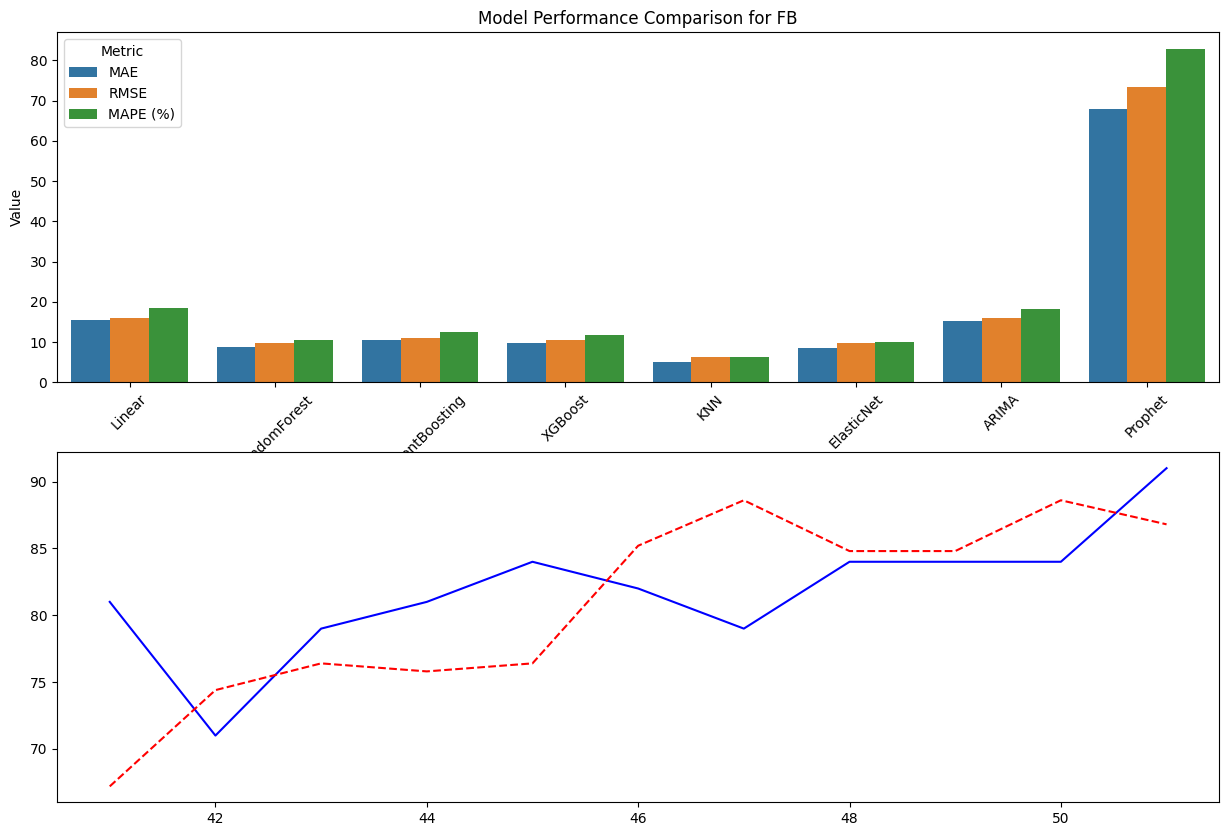

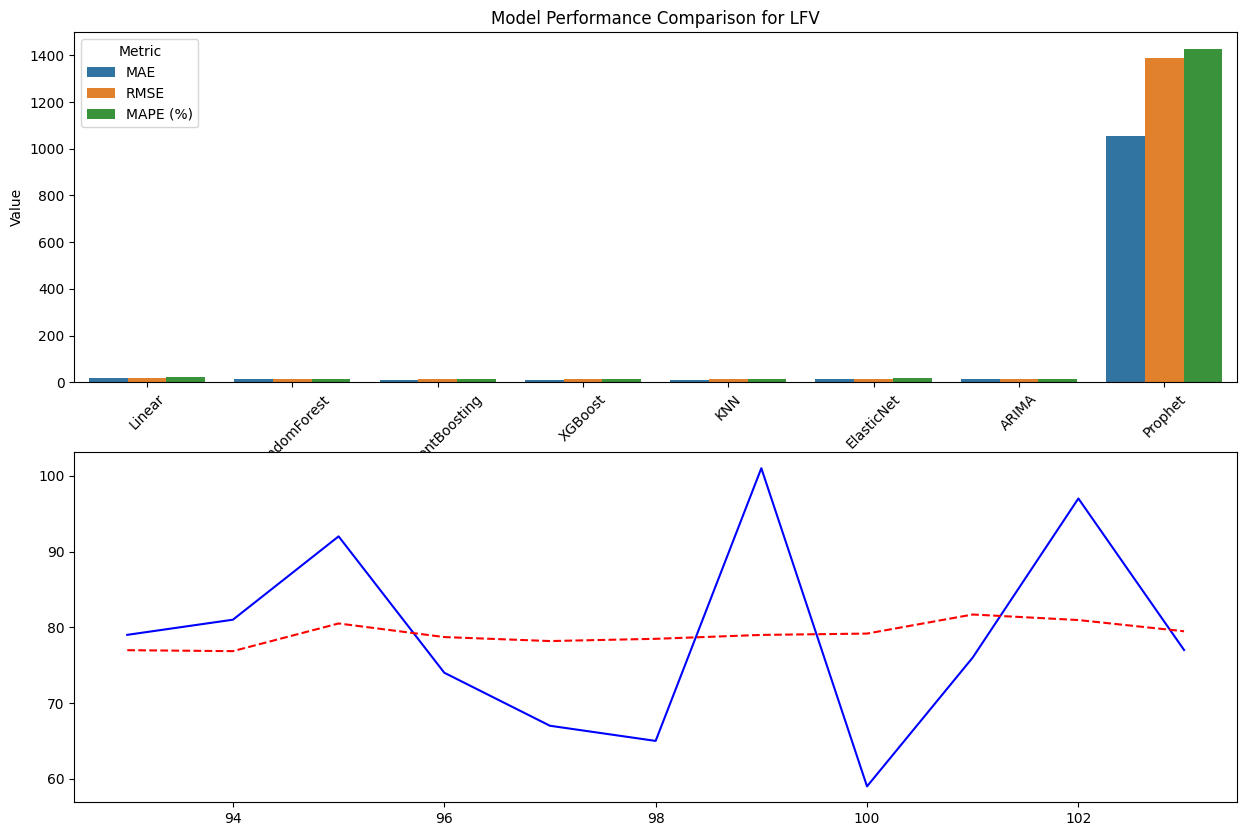

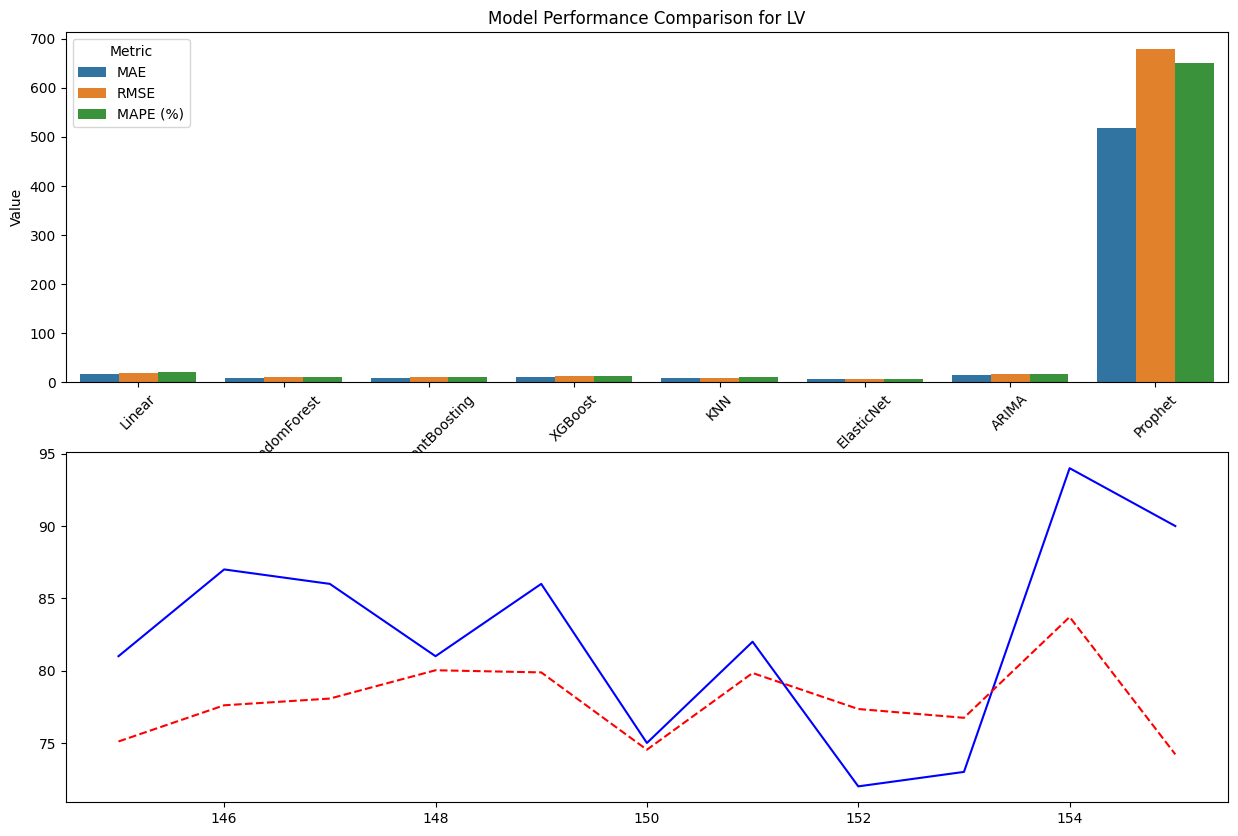

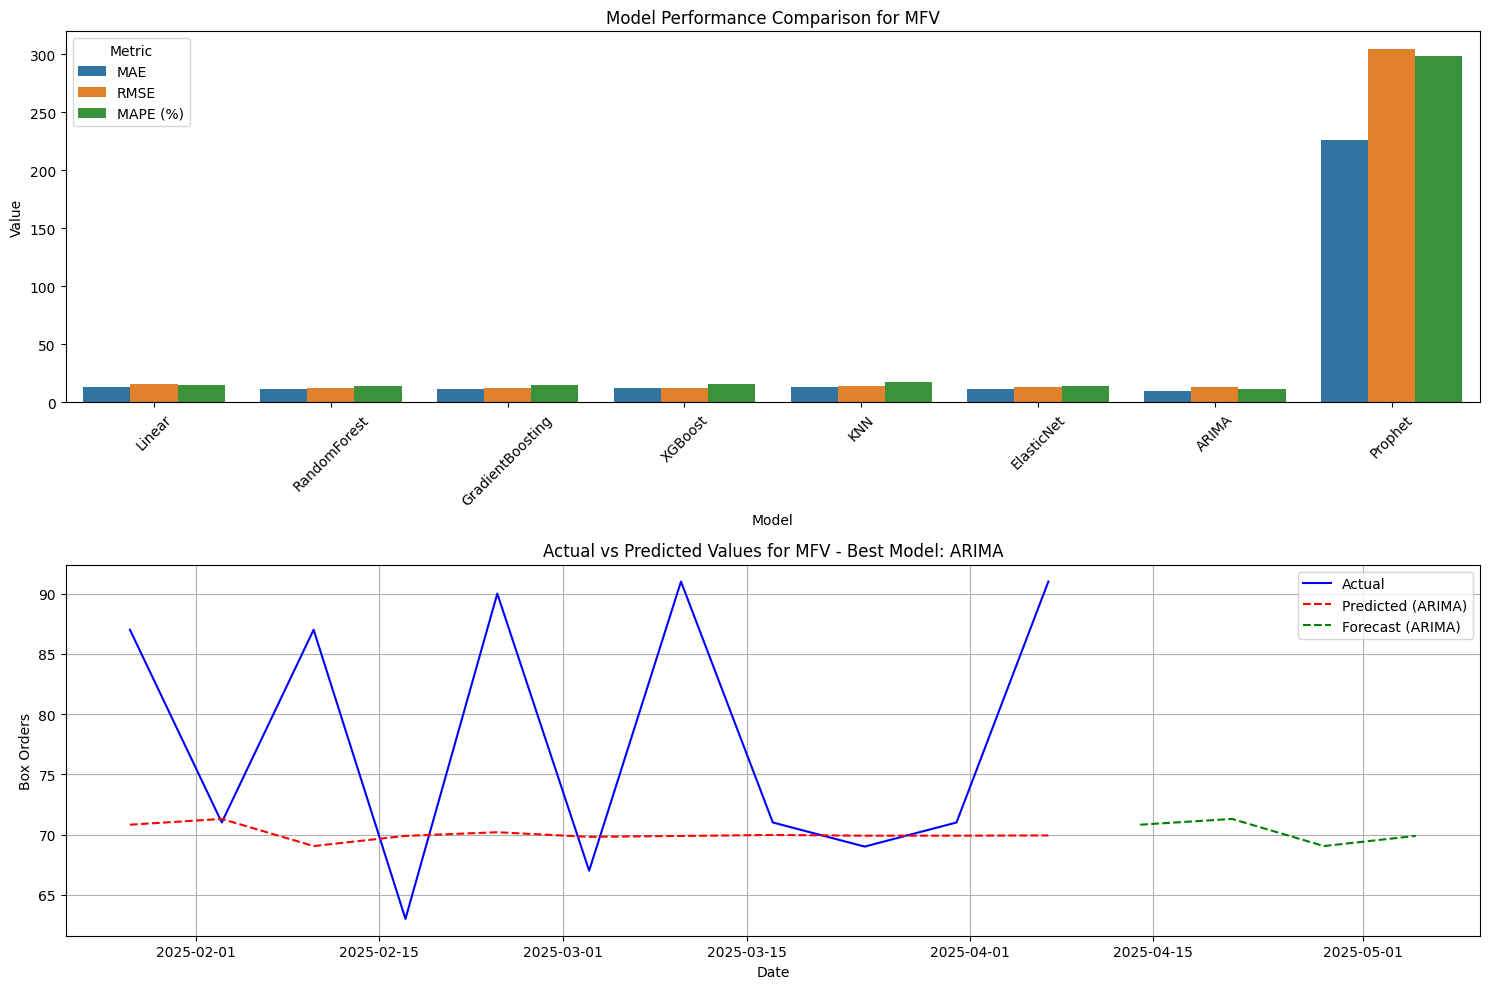

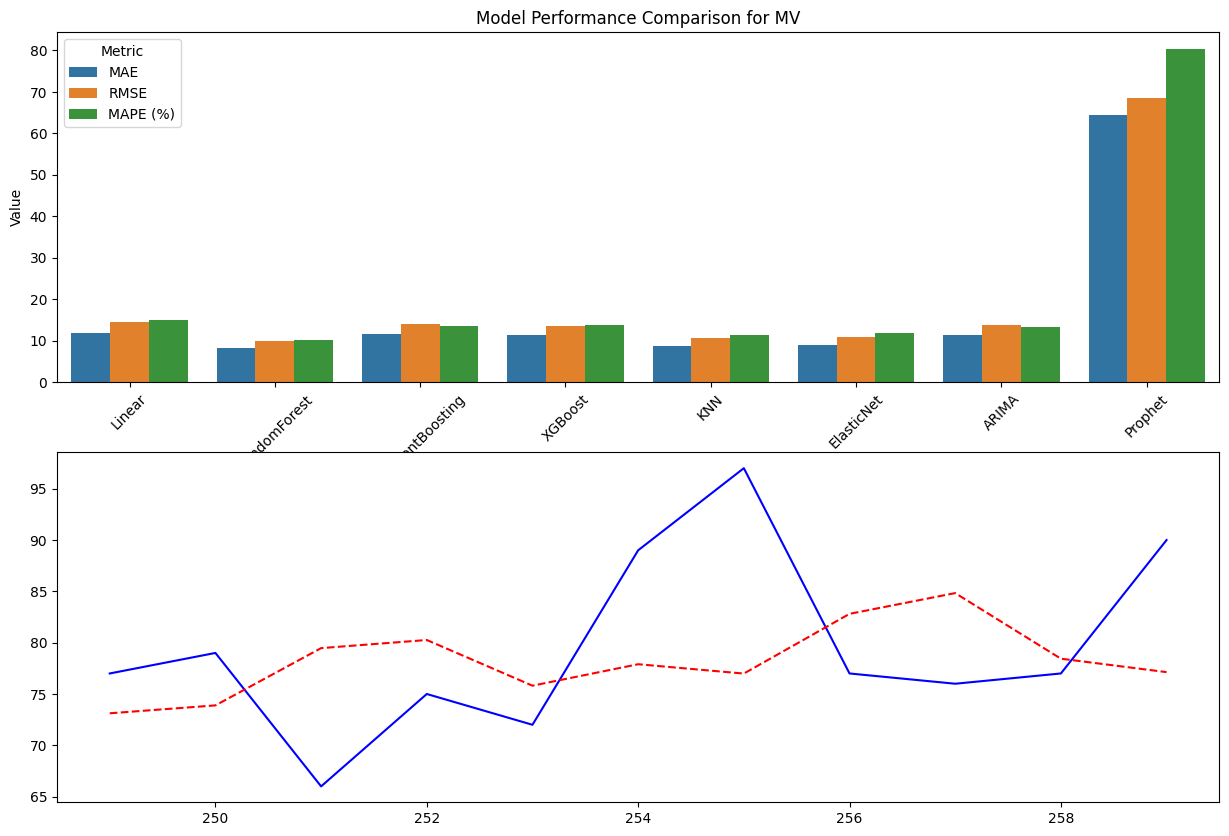

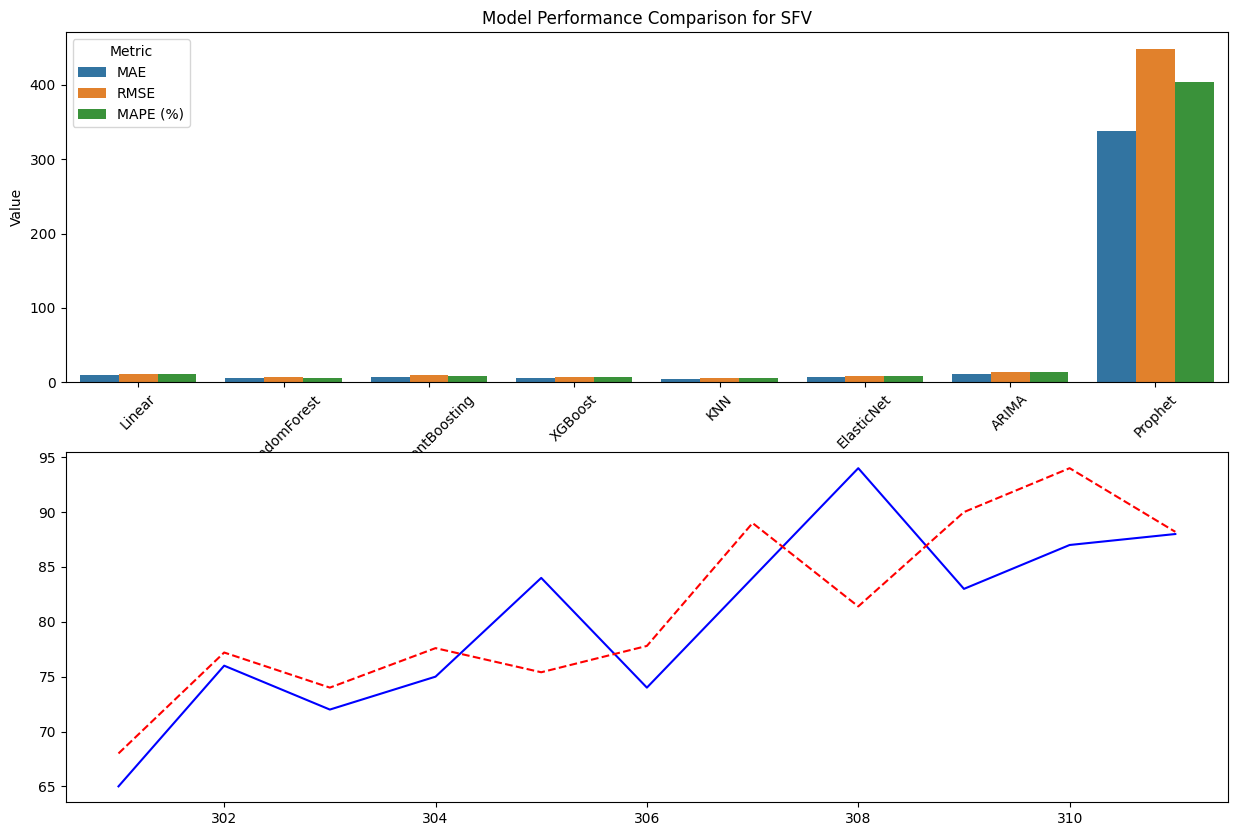

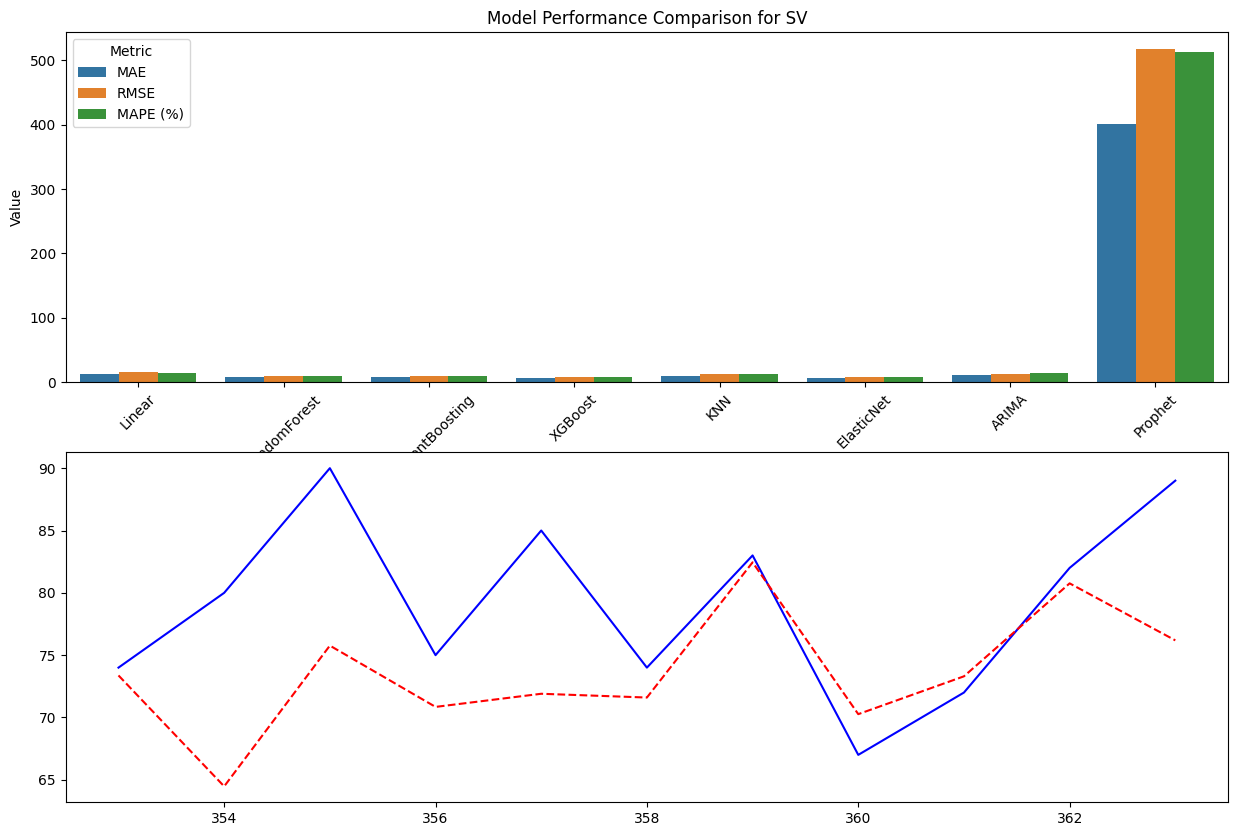

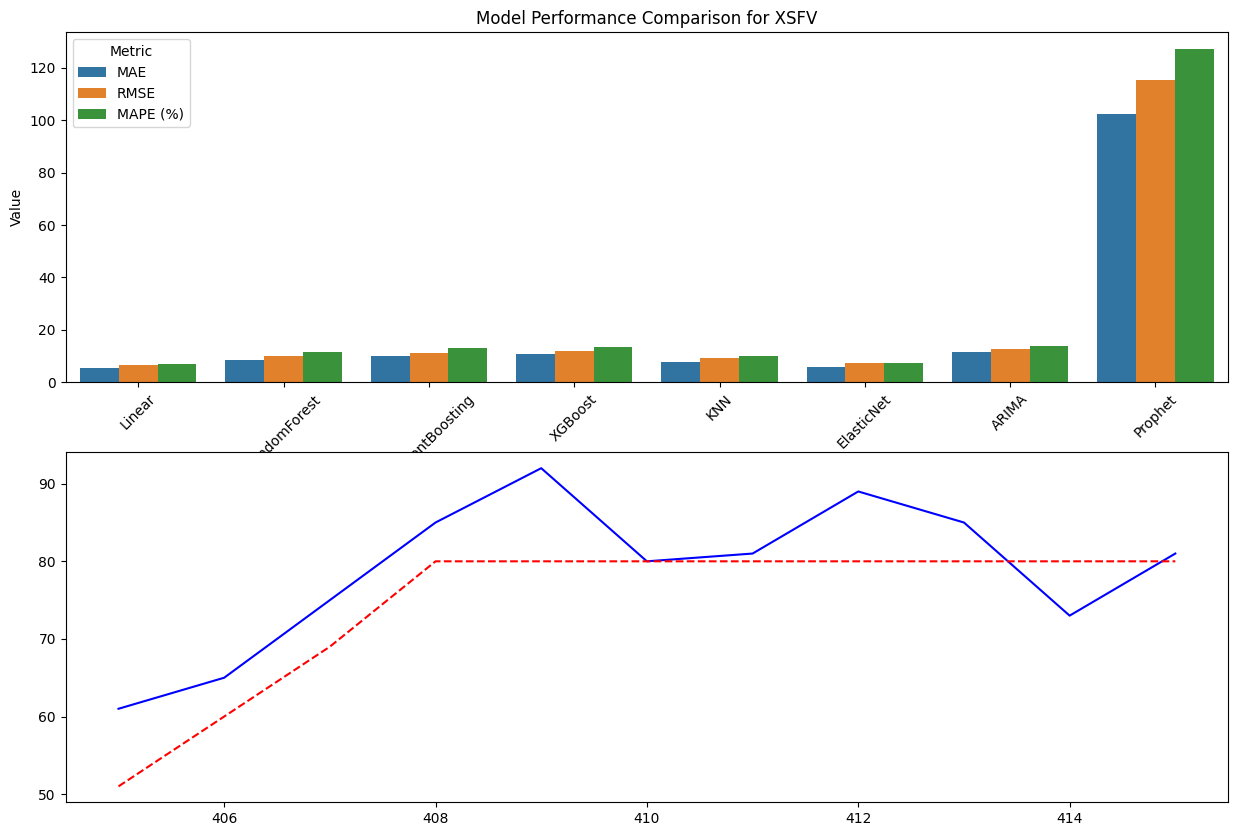

In [7]:
box_types = feature_engineered_data['box_type'].unique()
df = feature_engineered_data.copy()    
    # Store results for all box types
all_results = {}
best_models = {}

# Train models for each box type
for box_type in box_types:
    print(f"\nProcessing box type: {box_type}")
    box_data = df[df['box_type'] == box_type].copy()
    
    # Skip if not enough data
    if len(box_data) < 10:
        print(f"Not enough data for {box_type}. Skipping.")
        continue
    
    # Train and evaluate models
    results, best_model_name = train_and_evaluate_models(box_data)
    
    if results:
        all_results[box_type] = results
        best_models[box_type] = best_model_name
    

In [8]:
from train_global_model import train_global_model



Training global models for all box types...

Performing feature selection based on correlation...
Feature correlation heatmap saved as feature_correlation_heatmap.png
Removing 6 highly correlated features: ['week_of_year', 'quarter', 'day_of_year', 'rolling_mean_8', 'rolling_min_4', 'rolling_max_4']
Selected 24 features after correlation filtering
Checking for NaN values in features...

Training RandomForest model...
RandomForest model performance: MAE = 7.57, RMSE = 9.27, MAPE = 9.57%

Top 10 most important features:
                    Feature  Importance
22           rolling_mean_4    0.581689
23            rolling_std_4    0.078021
2        weekly_subscribers    0.046422
3   fortnightly_subscribers    0.045969
18                    lag_1    0.044342
19                    lag_2    0.037787
0         is_marketing_week    0.037395
20                    lag_3    0.037331
21                    lag_4    0.023708
5          subscriber_ratio    0.019126

Training GradientBoosting model...

08:34:40 - cmdstanpy - INFO - Chain [1] start processing


KNN model performance: MAE = 8.66, RMSE = 10.38, MAPE = 11.16%

Training time series models...

Training ARIMA model...
ARIMA model performance: MAE = 86.28, RMSE = 92.72, MAPE = 13.24%

Training global Prophet model...


08:34:40 - cmdstanpy - INFO - Chain [1] done processing


Prophet model performance: MAE = 2928.01, RMSE = 3768.63, MAPE = 458.66%

Best model: RandomForest (Type: ML)
MAE: 7.57
RMSE: 9.27
MAPE: 9.57%
Historical proportion for FB: 12.43%
Historical proportion for LFV: 12.43%
Historical proportion for LV: 12.78%
Historical proportion for MFV: 12.44%
Historical proportion for MV: 12.57%
Historical proportion for SFV: 12.47%
Historical proportion for SV: 12.43%
Historical proportion for XSFV: 12.44%

Generating forecast for FB...

Generating forecast for LFV...

Generating forecast for LV...

Generating forecast for MFV...

Generating forecast for MV...

Generating forecast for SFV...

Generating forecast for SV...

Generating forecast for XSFV...
Detailed box type predictions visualization saved as box_type_predictions_detail.png

Total forecasted box demand for next 4 weeks:
week_1: 643 boxes
week_2: 646 boxes
week_3: 634 boxes
week_4: 634 boxes

Forecast results saved to 'box_demand_forecast.csv' and 'box_demand_forecast_pivot.csv'
Feature im

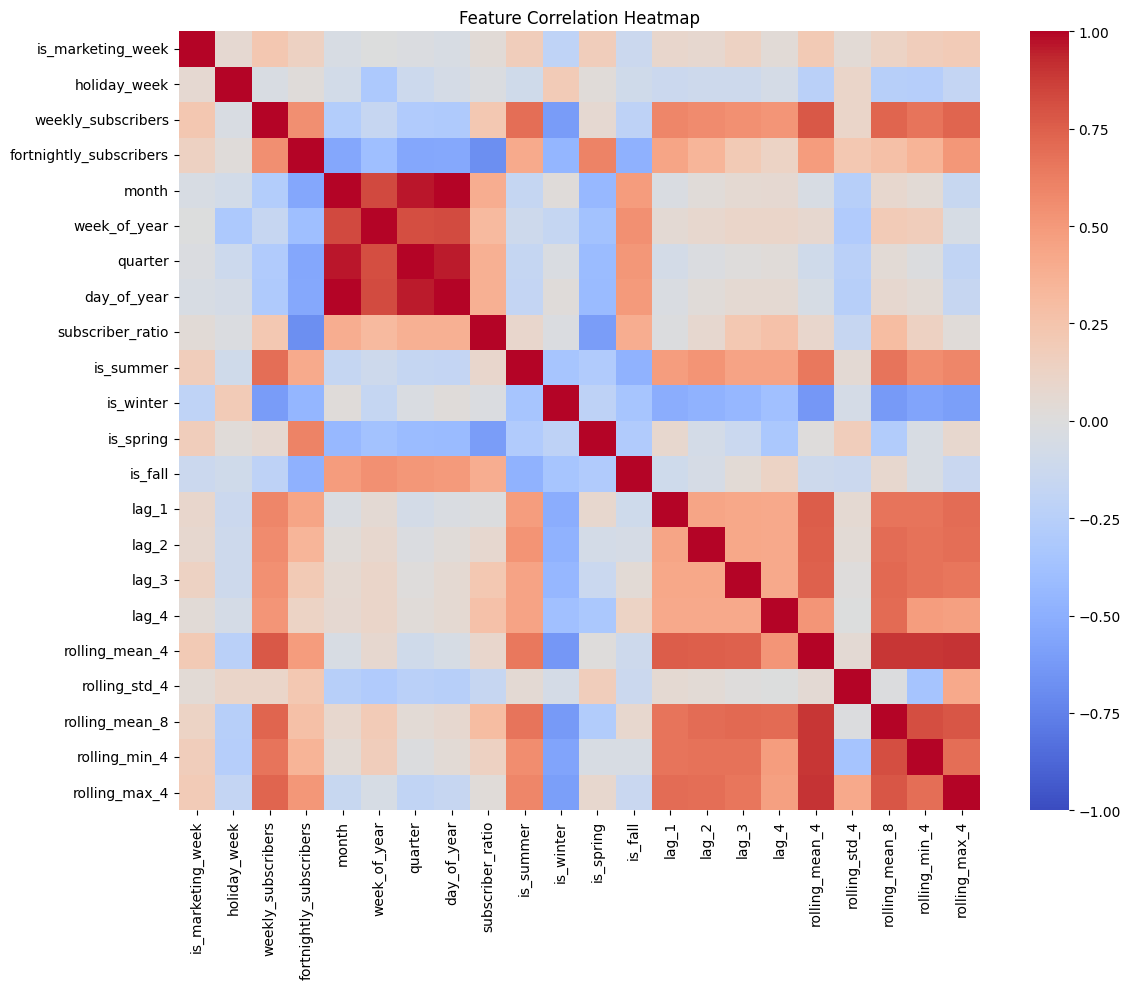

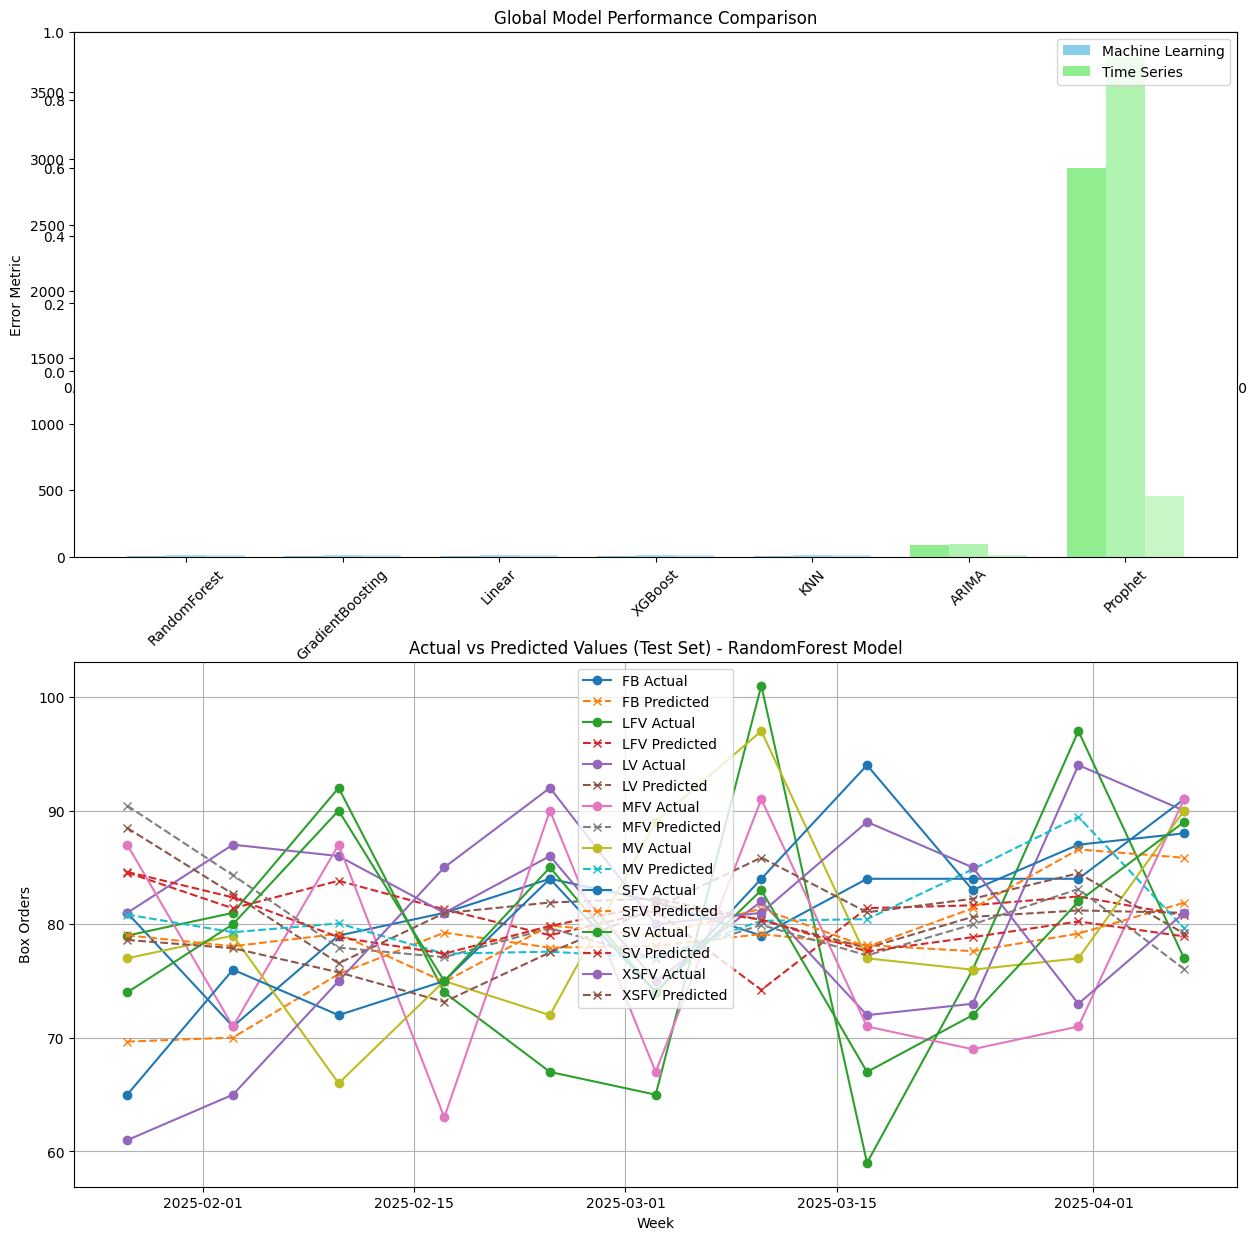

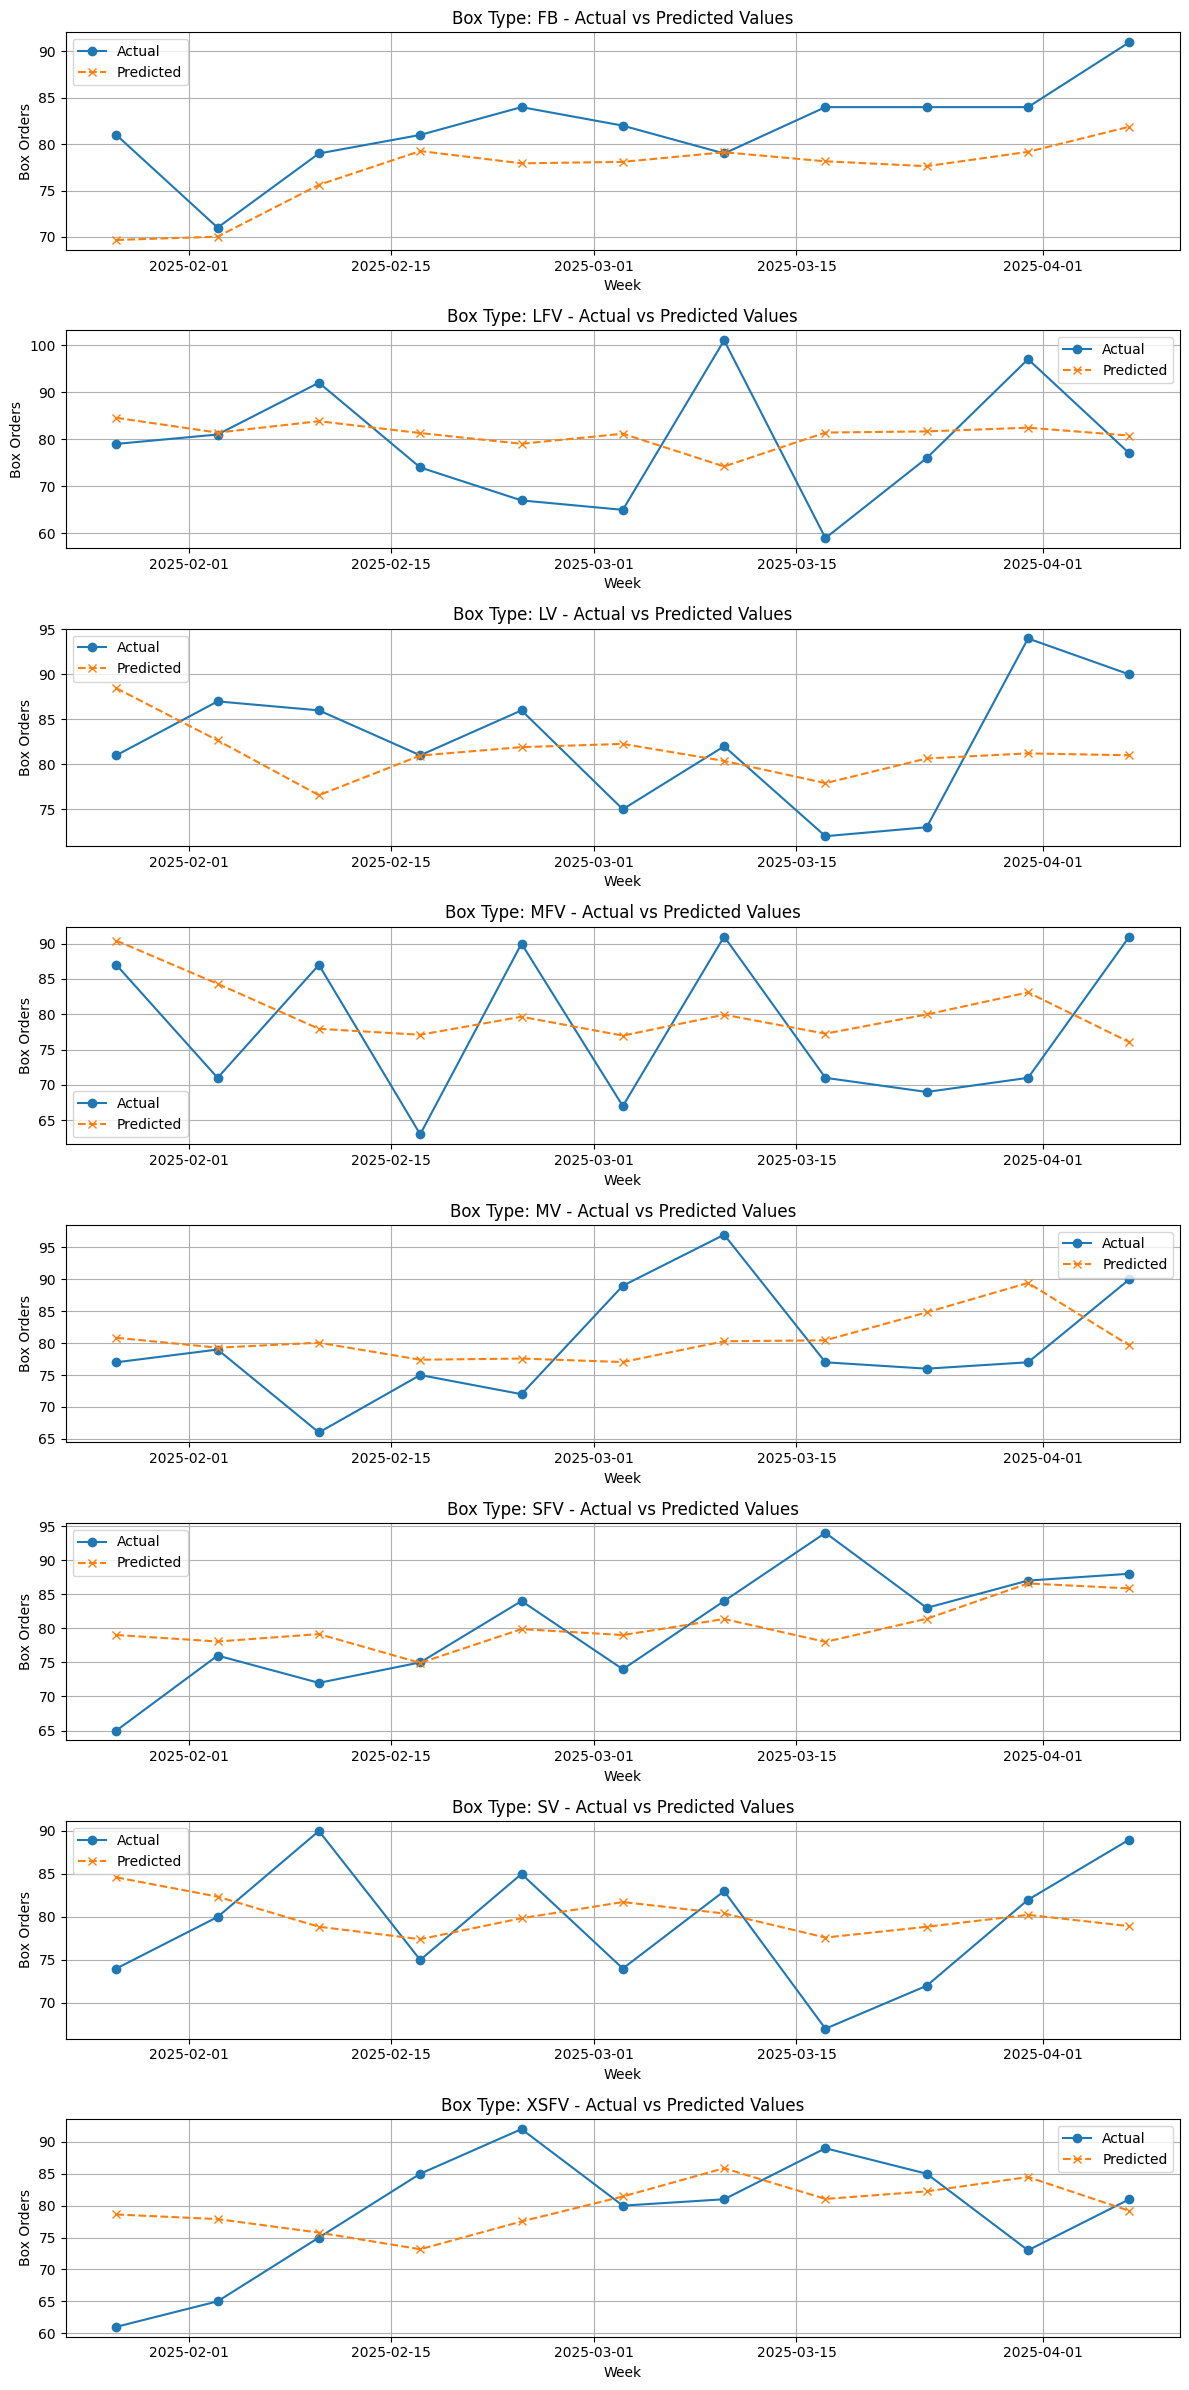

<Figure size 1500x1500 with 0 Axes>

In [9]:
model, results, feature_importance = train_global_model(df)

# Create forecast summary
forecast_summary = []
for box_type, forecast_values in results['forecasts'].items():
    for i, value in enumerate(forecast_values):
        forecast_summary.append({
            'box_type': box_type,
            'model': 'GlobalRandomForest',
            'forecast_week': i+1,
            'forecast_value': value,
            'mae': results['mae'],
            'rmse': results['rmse']
        })

# Create forecast summary dataframe
forecast_df = pd.DataFrame(forecast_summary)
forecast_df.to_csv('box_demand_forecast.csv', index=False)

# Create pivot table for easier reading
forecast_pivot = forecast_df.pivot_table(
    index=['box_type', 'model', 'mae', 'rmse'], 
    columns='forecast_week', 
    values='forecast_value'
)
forecast_pivot.columns = [f'Week {i}' for i in forecast_pivot.columns]
forecast_pivot.to_csv('box_demand_forecast_pivot.csv')

# Save feature importance
feature_importance.to_csv('feature_importance.csv', index=False)

# Calculate total forecasted demand for next 4 weeks
total_forecast = {}
for week in range(1, 5):
    week_data = forecast_df[forecast_df['forecast_week'] == week]
    total_forecast[f'week_{week}'] = week_data['forecast_value'].sum()

print("\nTotal forecasted box demand for next 4 weeks:")
for week, total in total_forecast.items():
    print(f"{week}: {total:.0f} boxes")

print("\nForecast results saved to 'box_demand_forecast.csv' and 'box_demand_forecast_pivot.csv'")
print("Feature importance saved to 'feature_importance.csv'")

In [10]:
model

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [11]:
results['forecasts']

{'FB': [np.float64(81.89),
  np.float64(82.155),
  np.float64(82.45),
  np.float64(82.465)],
 'LFV': [np.float64(80.77),
  np.float64(82.065),
  np.float64(77.93),
  np.float64(77.45)],
 'LV': [np.float64(81.005),
  np.float64(82.125),
  np.float64(78.185),
  np.float64(78.265)],
 'MFV': [np.float64(76.055),
  np.float64(75.81),
  np.float64(74.83),
  np.float64(77.18)],
 'MV': [np.float64(79.655),
  np.float64(78.625),
  np.float64(78.07),
  np.float64(78.47)],
 'SFV': [np.float64(85.85),
  np.float64(85.98),
  np.float64(84.665),
  np.float64(83.325)],
 'SV': [np.float64(78.93),
  np.float64(80.255),
  np.float64(77.995),
  np.float64(78.685)],
 'XSFV': [np.float64(79.185),
  np.float64(78.57),
  np.float64(79.725),
  np.float64(78.305)]}


Performing feature selection based on correlation...
Feature correlation heatmap saved as feature_correlation_heatmap.png
Removing 6 highly correlated features: ['week_of_year', 'quarter', 'day_of_year', 'rolling_mean_8', 'rolling_min_4', 'rolling_max_4']
Selected 24 features after correlation filtering
Checking for NaN values in features...
Starting GradientBoosting model fine-tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 3, 'learning_rate': 0.1}
Best MAE score: 4.96
Tuned GradientBoosting performance: MAE = 7.25, RMSE = 8.96, MAPE = 9.31%
Default GradientBoosting performance: MAE = 7.59, RMSE = 9.23, MAPE = 9.68%
Best model saved as 'best_gradient_boosting_model.pkl'
Feature importance visualization saved as 'gb_feature_importance.png'
Actual vs Predicted visualization saved as 'gb_actual_vs_predicted.png'

Fine-tu

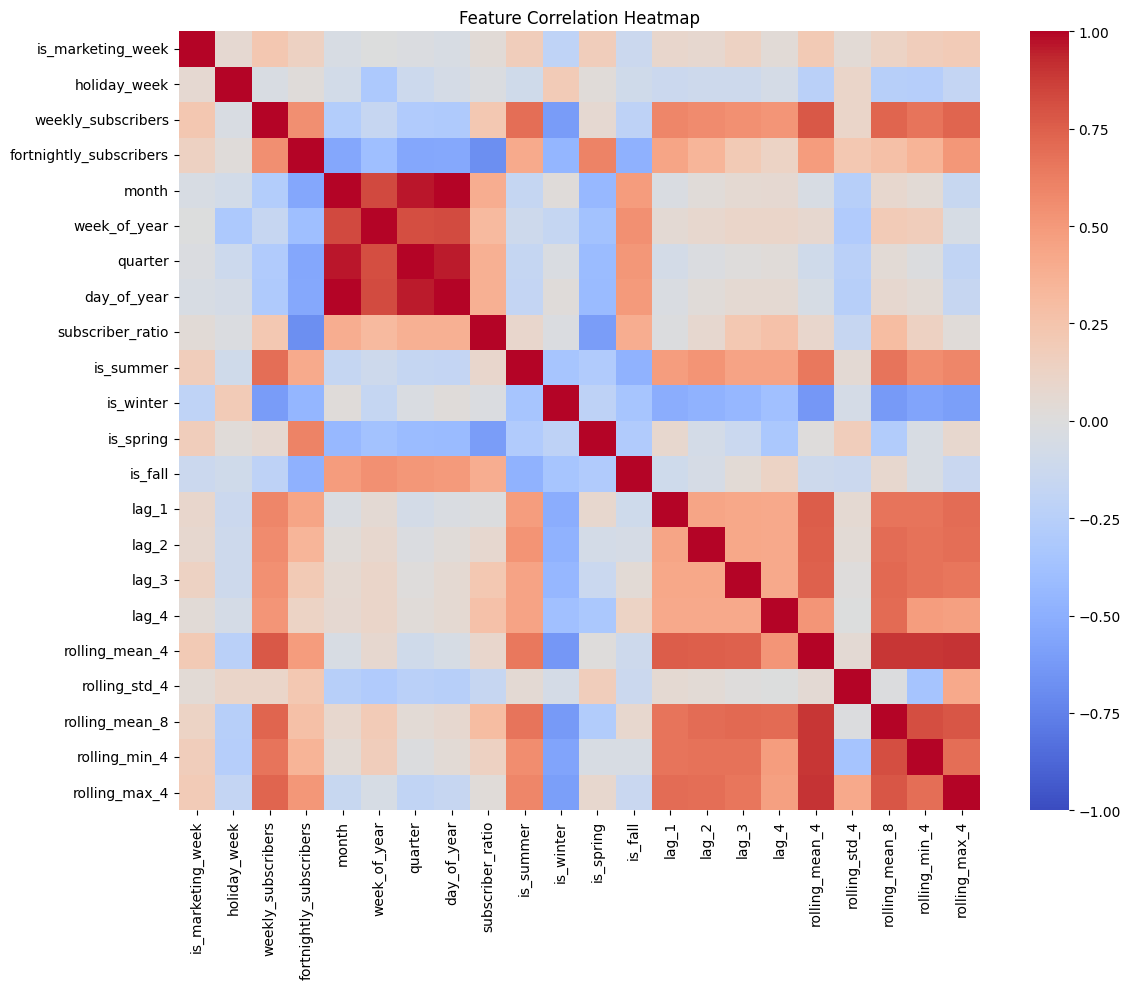

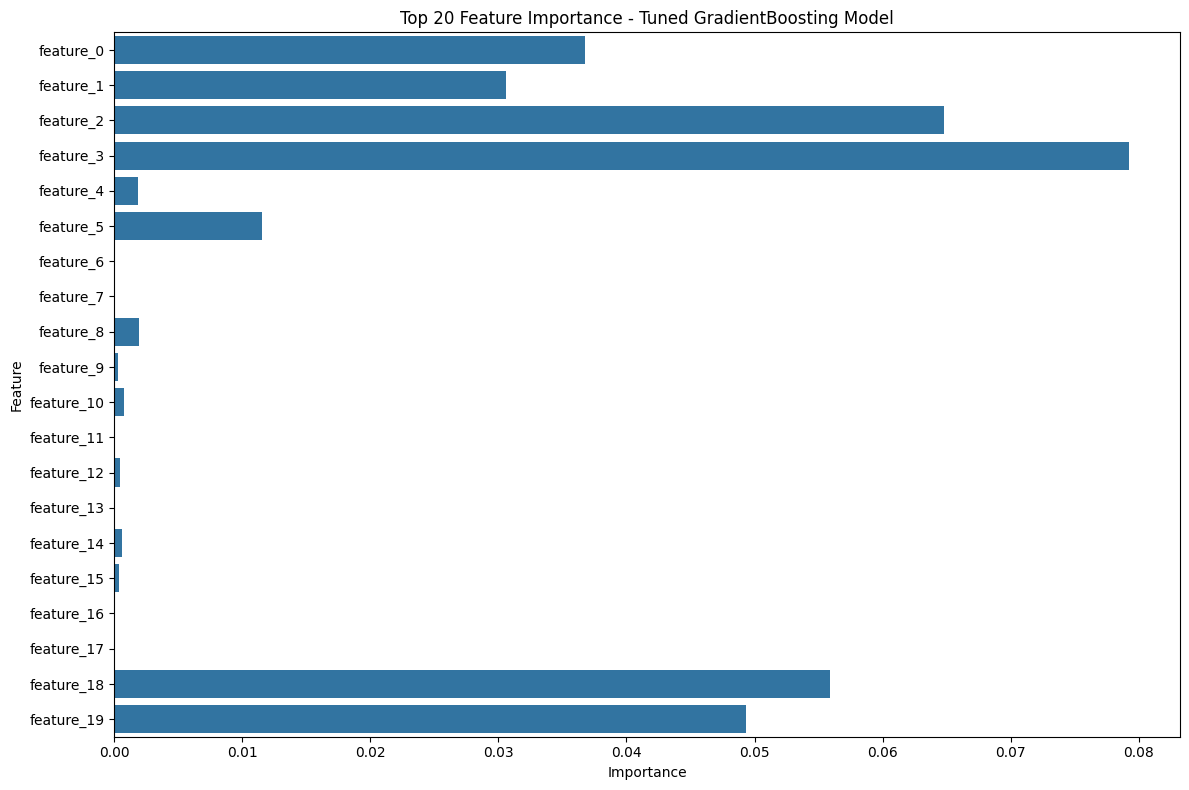

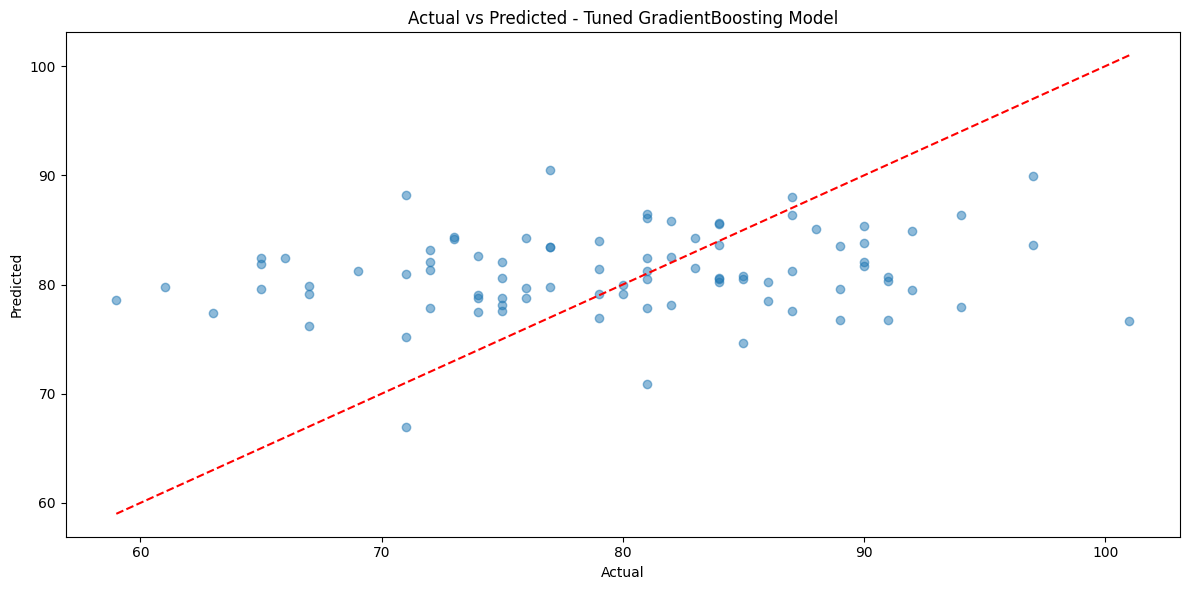

In [12]:
from fine_tune_gb import fine_tune_gradient_boosting
from train_global_model import * 
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test, feature_names, _, _ = feature_engineering(df)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
best_model, metrics = fine_tune_gradient_boosting(X_train_scaled, y_train, X_test_scaled, y_test, feature_names)
# Print summary
print("\nFine-tuning complete!")
print(f"Best MAE: {metrics['mae']:.2f}")
print(f"Best RMSE: {metrics['rmse']:.2f}")
print(f"Best MAPE: {metrics['mape']:.2f}%")
print("\nTop 10 important features:")
print(metrics['feature_importance'].head(10))



